In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [ ]:
train.shape, test.shape, submission.shape

# 2. EDA & 전처리

In [ ]:
df = pd.concat([train, test])
df.shape

In [ ]:
train.info

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

## 컬럼 분류

In [4]:
data = []

for f in train.columns:
    dtl = ''
    if f == 'voted':
        gubun = 'target'
    elif 'Q' in f:
        dtl = f[1]
        if 'A' in f:
            gubun = 'Q_A'
        if 'E' in f:
            gubun = 'Q_E'
    elif 'tp' in f:           
        gubun = 'tp'            
    elif 'wf' in f:           
        gubun = 'wf'
    elif 'wr' in f:           
        gubun = 'wr'    
    else:
        gubun = 'cat'
        
    f_dict = {
        'col':f,
        'gbn':gubun,
        'dtl':dtl
    }
            
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns =['col', 'gbn', 'dtl'])
meta.set_index('col', inplace=True)
meta

,gbn,dtl
col,,
QaA,Q_A,a
QaE,Q_E,a
QbA,Q_A,b
QbE,Q_E,b
QcA,Q_A,c
...,...,...
wr_09,wr,
wr_10,wr,
wr_11,wr,


## CovariateShift

In [5]:
train['race']=pd.factorize(train['race'])[0]
test['race']=pd.factorize(test['race'])[0]

train = pd.get_dummies(train, columns=['race'])
test = pd.get_dummies(test, columns=['race'])

train.drop(['race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6'], axis=1, inplace=True)
test.drop(['race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6'], axis=1, inplace=True)


train.drop('religion', axis=1, inplace=True)
test.drop('religion', axis=1, inplace=True)

### Q_A

In [ ]:
Q_A = meta[meta.gbn=='Q_A'].index

train[Q_A].describe()
train[Q_A].head(3)

### Q_A 1/5 count

In [ ]:
# Q_A: 1~5 1/5 극단값 선택한 count 추출
train['Q_A15'] = 0
train['Q_A3'] = 0

test['Q_A15'] = 0
test['Q_A3'] = 0

In [ ]:
%%time
for f in Q_A:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'Q_A15'] = train.loc[i, 'Q_A15']+1
        elif v == 3:
            train.loc[i, 'Q_A3'] = train.loc[i, 'Q_A3']+1
        elif v == 5:
            train.loc[i, 'Q_A15'] = train.loc[i, 'Q_A15']+1            

In [ ]:
%%time
for f in Q_A:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'Q_A15'] = test.loc[i, 'Q_A15']+1
        elif v == 3:
            test.loc[i, 'Q_A3'] = test.loc[i, 'Q_A3']+1            
        elif v == 5:
            test.loc[i, 'Q_A15'] = test.loc[i, 'Q_A15']+1                        

### Q_E

In [6]:
Q_E = meta[meta.gbn == 'Q_E'].index

train[Q_E].describe()
train[Q_E].head()

,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
count,4.553200e+04,4.553200e+04,45532.000000,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,45532.000000,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04
mean,9.453570e+02,2.189589e+03,1484.294518,1.490672e+03,1.899292e+03,1.850650e+03,1.284608e+03,4.584272e+03,4.068434e+03,2.576363e+03,2.038986e+03,3.741018e+03,2.050287e+03,959.880502,1.435762e+03,1.633479e+03,1.154352e+03,2.470808e+03,1.164117e+03,2.240057e+03
std,1.307565e+04,3.351027e+04,8977.664318,1.092260e+04,1.670765e+04,7.608236e+04,9.756584e+03,5.020265e+05,1.141738e+05,5.411432e+04,3.069164e+04,3.663672e+05,7.530787e+04,5869.964127,1.084997e+04,2.600221e+04,2.250689e+04,1.482890e+05,7.433515e+03,6.730924e+04
min,2.500000e+01,2.500000e+01,25.000000,2.600000e+01,2.500000e+01,2.500000e+01,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,2.500000e+01,25.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,2.500000e+01,2.500000e+01
25%,4.040000e+02,8.750000e+02,651.000000,6.790000e+02,8.340000e+02,5.040000e+02,5.490000e+02,1.077000e+03,1.259000e+03,9.020000e+02,8.590000e+02,8.060000e+02,6.500000e+02,428.000000,6.380000e+02,7.060000e+02,4.610000e+02,7.940000e+02,5.270000e+02,7.330000e+02
50%,5.570000e+02,1.218000e+03,899.000000,9.310000e+02,1.154000e+03,7.120000e+02,7.720000e+02,1.464000e+03,1.800000e+03,1.260000e+03,1.178000e+03,1.125000e+03,9.060000e+02,596.000000,8.830000e+02,9.700000e+02,6.520000e+02,1.117000e+03,7.470000e+02,1.020000e+03
75%,8.270000e+02,1.838000e+03,1335.000000,1.355000e+03,1.656000e+03,1.078000e+03,1.150000e+03,2.090000e+03,2.761000e+03,1.899000e+03,1.721000e+03,1.649000e+03,1.342000e+03,891.000000,1.300000e+03,1.409000e+03,9.820000e+02,1.664000e+03,1.124000e+03,1.526000e+03
max,2.413960e+06,5.580395e+06,871557.000000,1.552821e+06,1.919926e+06,1.176370e+07,1.068252e+06,1.070860e+08,1.703586e+07,9.910006e+06,4.824953e+06,7.754351e+07,1.410832e+07,606694.000000,1.309739e+06,4.650742e+06,4.277510e+06,3.159328e+07,1.286581e+06,1.155650e+07


,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
index,,,,,,,,,,,,,,,,,,,,
0,363,1370,997,1024,1577,539,586,1095,1142,1287,883,851,851,816,579,924,366,876,633,1115
1,647,1313,3387,2969,4320,2190,826,4082,1867,1264,2943,3927,4329,1828,1214,2414,1356,3039,4304,1346
2,1623,1480,1021,3374,1333,531,1167,1016,2653,1569,998,2547,918,2153,1304,1131,937,1327,1170,1409
3,504,2311,992,3245,357,1519,159,2275,2809,5614,3219,1296,9046,1216,1169,23868,581,8830,2392,1312
4,927,707,556,1062,1014,628,991,1259,1153,1388,740,1181,547,575,754,1140,323,1070,583,1889


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train[Q_E])
scaled = scaler.transform(train[Q_E])
scaled_df = pd.DataFrame(data=scaled, columns=Q_E)
train = pd.concat([train.drop(Q_E, axis=1), scaled_df], axis=1)

scaler = StandardScaler()
scaler.fit(test[Q_E])
scaled = scaler.transform(test[Q_E])
scaled_df = pd.DataFrame(data=scaled, columns=Q_E)
test = pd.concat([test.drop(Q_E, axis=1), scaled_df], axis=1)

StandardScaler()

StandardScaler()

### tp

In [ ]:
# 0~7 
tp = meta[meta.gbn=='tp'].index

train[tp].describe()
train[tp].head(3)

In [ ]:
# tp: 1,7 극단값 선택한 count 추출, 4 중간값 선택 count 
train['tp17'] = 0
train['tp4'] = 0

test['tp17'] = 0
test['tp4'] = 0

In [ ]:
%%time
for f in tp:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'tp17'] = train.loc[i, 'tp17']+1
        elif v == 7:
            train.loc[i, 'tp17'] = train.loc[i, 'tp17']+1
        elif v == 4:
            train.loc[i, 'tp4'] = train.loc[i, 'tp4']+1            

In [ ]:
%%time
for f in tp:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'tp17'] = test.loc[i, 'tp17']+1
        elif v == 7:
            test.loc[i, 'tp17'] = test.loc[i, 'tp17']+1
        elif v == 4:
            test.loc[i, 'tp4'] = test.loc[i, 'tp4']+1            

#### 극단값 중간값

In [ ]:
train['Q_A15tp17'] = train['Q_A15'] + train['tp17']
train['Q_A3tp4'] = train['Q_A3'] + train['tp4']

In [ ]:
test['Q_A15tp17'] = test['Q_A15'] + test['tp17']
test['Q_A3tp4'] = test['Q_A3'] + test['tp4']

In [ ]:
# 0/1
wf = meta[meta.gbn=='wf'].index
train[wf].describe()
train[wf].head(3)

In [ ]:
# 0/1
wr = meta[meta.gbn=='wr'].index
train[wr].describe()
train[wr].head(3)

## Target Encoding

### age_group

In [10]:
train['age_group_int'] = train['age_group'].str.replace('s','').astype('int')
test['age_group_int'] = test['age_group'].str.replace('s','').astype('int')

In [11]:
train['age_group_n_rows'] = train['age_group_int'].map(train.groupby('age_group_int').size())
test['age_group_n_rows'] = test['age_group_int'].map(test.groupby('age_group_int').size())

In [12]:
age_group_mean = train.groupby('age_group_int')['voted'].mean()
train['age_group_mean'] = train['age_group_int'].map(age_group_mean)
test['age_group_mean'] = test['age_group_int'].map(age_group_mean)

In [13]:
# train['voted'].mean() = 1.5468242115435298
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 1.5468242115435298*0.8) / (n_rows + 0.8)

In [14]:
train['age_group_mean_smoothing'] = train.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)
test['age_group_mean_smoothing'] = test.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)

In [15]:
train.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)
test.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)

### outlier

In [16]:
train = train[train.familysize < 25]

In [ ]:
train.shape, train.columns

In [ ]:
test.shape, test.columns

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [ ]:
train.columns

In [17]:
#col_cat = meta[(meta.gbn == 'Q_A') | (meta.gbn == 'cat')].index.values.tolist()
col_cat = ['QaA',
 'QbA',
 'QcA',
 'QdA',
 'QeA',
 'QfA',
 'QgA',
 'QhA',
 'QiA',
 'QjA',
 'QkA',
 'QlA',
 'QmA',
 'QnA',
 'QoA',
 'QpA',
 'QqA',
 'QrA',
 'QsA',
 'QtA',
 'age_group',
 'education',
 'engnat',
 'familysize',
 'gender',
 'hand',
 'married',
# 'race_0',
 #'religion',
 'urban'
#,'Priority'
          ]

In [18]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'voted'
          , categorical_features=col_cat
          , numeric_features = ['race_0']#,,'tp17','tp4','Q_A15','Q_A3','Q_A15tp17','Q_A3tp4']#['Q_A1','Q_A3','Q_A5','tp17','tp4','Q_A15tp17','Q_A3tp4']
          #, ignore_features =['Priority']#'religion', 'race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45524, 77)"
4,Missing Values,False
5,Numeric Features,22
6,Categorical Features,54
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 23.9 s


In [19]:
best_5 = compare_models(sort = 'AUC', n_select = 5
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6940,0.7643,0.6511,0.7556,0.6994,0.3913,0.3959,20.0336
1,Light Gradient Boosting Machine,0.6917,0.7618,0.6514,0.7518,0.6980,0.3865,0.3906,1.0477
2,CatBoost Classifier,0.6917,0.7617,0.6548,0.7496,0.6990,0.3859,0.3896,18.2567
3,Linear Discriminant Analysis,0.6862,0.7582,0.6541,0.7416,0.6951,0.3745,0.3777,1.0083
4,Extra Trees Classifier,0.6853,0.7577,0.6343,0.7515,0.6879,0.3751,0.3806,3.0939
5,Logistic Regression,0.6842,0.7567,0.6599,0.7354,0.6956,0.3695,0.3719,0.9372
6,Ada Boost Classifier,0.6855,0.7541,0.6500,0.7429,0.6933,0.3735,0.3771,5.0489
7,Extreme Gradient Boosting,0.6679,0.7387,0.6607,0.7115,0.6851,0.3348,0.3359,11.0356
8,Naive Bayes,0.6339,0.7117,0.8030,0.6337,0.7052,0.2388,0.2549,0.1302
9,Random Forest Classifier,0.6488,0.7075,0.5944,0.7152,0.6492,0.3035,0.3088,0.3026


In [20]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6957,0.7652,0.6545,0.7562,0.7017,0.3943,0.3986
1,0.6996,0.7697,0.6623,0.7580,0.7069,0.4017,0.4056
2,0.6960,0.7688,0.6470,0.7612,0.6995,0.3961,0.4014
3,0.6898,0.7631,0.6544,0.7468,0.6976,0.3819,0.3855
4,0.6920,0.7663,0.6445,0.7561,0.6959,0.3879,0.3930
Mean,0.6946,0.7666,0.6525,0.7557,0.7003,0.3924,0.3968
SD,0.0034,0.0024,0.0063,0.0048,0.0038,0.0068,0.0070


In [21]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6967,0.7628,0.6561,0.7568,0.7029,0.3962,0.4005


In [22]:
%%time
final_model = finalize_model(blended)

Wall time: 8min 18s


In [23]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [24]:
submission['voted'] = predictions['Score']

# 5. 제출

In [25]:
submission.to_csv('output/20201010-3.csv')

In [26]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7010,0.7703,0.6590,0.7621,0.7068,0.4051,0.4095
1,0.6840,0.7480,0.6451,0.7432,0.6907,0.3710,0.3749
2,0.6885,0.7597,0.6475,0.7488,0.6945,0.3801,0.3843
3,0.7069,0.7752,0.6615,0.7700,0.7116,0.4170,0.4220
4,0.6992,0.7739,0.6566,0.7607,0.7048,0.4016,0.4061
5,0.6885,0.7619,0.6459,0.7498,0.6940,0.3803,0.3847
6,0.6924,0.7657,0.6426,0.7582,0.6957,0.3889,0.3944
7,0.6897,0.7575,0.6604,0.7433,0.6994,0.3810,0.3839
8,0.7031,0.7757,0.6546,0.7680,0.7068,0.4100,0.4154
9,0.6870,0.7551,0.6374,0.7522,0.6901,0.3783,0.3836


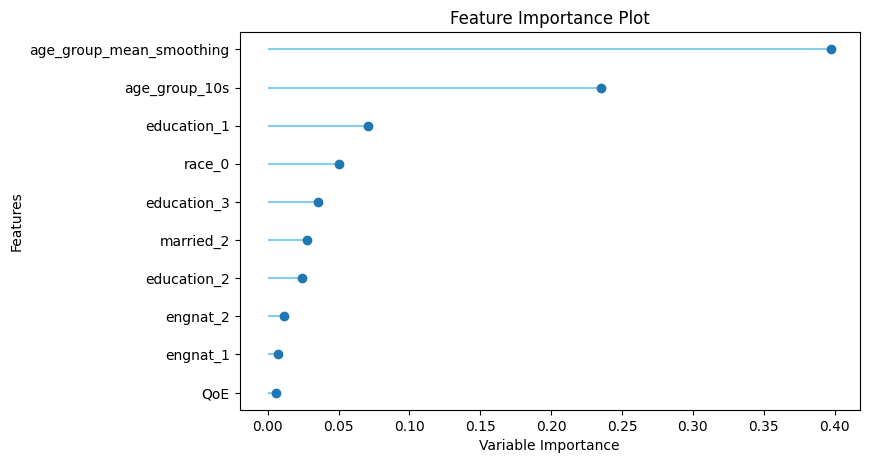

In [27]:
plot_model(estimator = gbc, plot = 'feature')

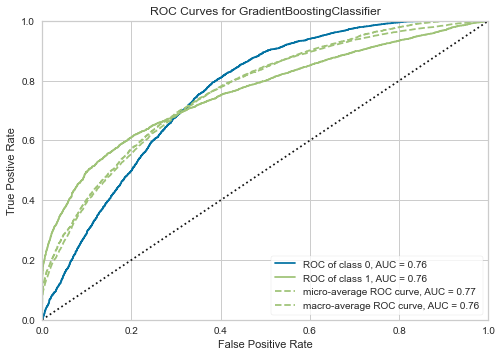

In [28]:
plot_model(estimator = gbc, plot = 'auc')

In [29]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6979,0.7637,0.6598,0.7566,0.7049,0.3984,0.4023
1,0.6858,0.7521,0.6467,0.7450,0.6924,0.3745,0.3785
2,0.6916,0.7601,0.6500,0.7524,0.6974,0.3864,0.3907
3,0.7024,0.7709,0.6615,0.7628,0.7085,0.4076,0.4119
4,0.7019,0.7753,0.6574,0.7645,0.7069,0.4072,0.4120
5,0.6835,0.7572,0.6475,0.7411,0.6912,0.3697,0.3733
6,0.6924,0.7609,0.6459,0.7562,0.6967,0.3885,0.3935
7,0.6740,0.7474,0.6382,0.7312,0.6816,0.3508,0.3542
8,0.7018,0.7772,0.6563,0.7648,0.7064,0.4070,0.4119
9,0.6861,0.7534,0.6505,0.7432,0.6938,0.3747,0.3782


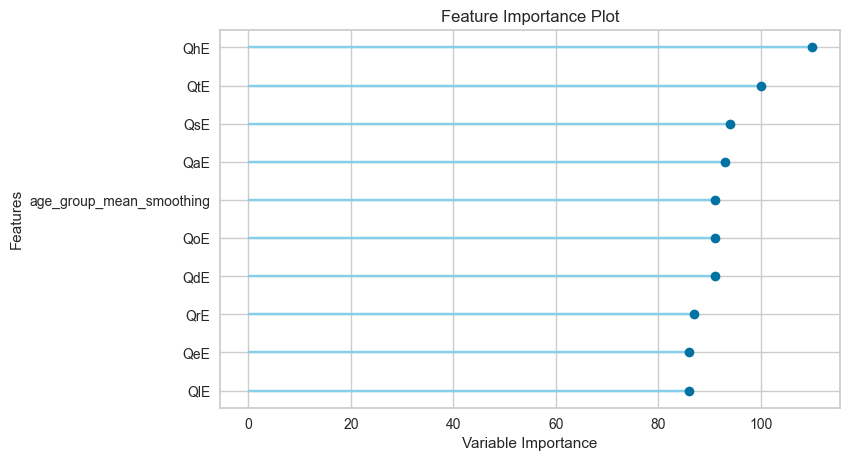

In [30]:
plot_model(estimator = lightgbm, plot = 'feature')